In [1]:
import os

import qiskit
import numpy as np
from numpy import pi

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ, transpile
from qiskit.providers.aer import noise
from qiskit.providers.aer import AerSimulator
import qiskit.ignis.mitigation.measurement as mc

from dotenv import load_dotenv
load_dotenv()


True

## Credentials/Backend

In [2]:
IBMQ # This makes the next cell work properly and I have no idea why

In [3]:
IBMQ.ibmq.enable_account(os.environ['TOKEN'])

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
dir(IBMQ.ibmq)
IBMQ.ibmq.providers()[0].backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [5]:
provider = IBMQ.ibmq.providers()[0]

backend = provider.get_backend('ibmqx2')
sim = AerSimulator.from_backend(backend)

## Parameters

In [6]:
detuning = 0.3
signal_strength = 0.2
dt = 0.1
Gamma = 1

theta = 2 * np.arcsin(np.sqrt(Gamma * dt))

## Circuit

In [7]:
z_arg = -detuning * dt / 2
y_arg = -signal_strength * dt

qreg_q = QuantumRegister(2, "q")
creg_c = ClassicalRegister(1, "c")

qc = QuantumCircuit(qreg_q, creg_c)

# for _ in range(35):
for _ in range(1):
    qc.u(z_arg, y_arg, z_arg, qreg_q[0])

    qc.cu(theta, 0, 0, 0, qreg_q[0], qreg_q[1])
    qc.cx(qreg_q[1], qreg_q[0])
    qc.measure(qreg_q[1], creg_c[0])
    qc.reset(qreg_q[1])

# qc.measure_all()

# qc.draw(fold=100)


## Tomography Setup

In [8]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

qpt_circs = state_tomography_circuits(qc, qreg_q[0])

C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  ci

In [9]:
qpt_circs[0].draw()

┌────────────────────────┐                   ┌───┐         ░ ┌───┐┌─┐
 q_0: ┤ U(-0.015,-0.02,-0.015) ├─────────■─────────┤ X ├─────────░─┤ H ├┤M├
      └────────────────────────┘┌────────┴────────┐└─┬─┘┌─┐      ░ └───┘└╥┘
 q_1: ──────────────────────────┤ U(0.6435,0,0,0) ├──■──┤M├─|0>──░───────╫─
                                └─────────────────┘     └╥┘      ░       ║ 
c0: 1/═══════════════════════════════════════════════════╬═══════════════╩═
                                                         ║               0 
                                                         ║                 
 c: 1/═══════════════════════════════════════════════════╩═════════════════
                                                         0

## Simulation

### Calibration Circuit

In [12]:
cal_qr = QuantumRegister(2)
cal_cr = ClassicalRegister(2)

meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0])
job_cal = sim.run(meas_calibs, shots=8192)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)

In [13]:
state_labels

['0', '1']

In [14]:
meas_fitter.cal_matrix

array([[0.93481445, 0.09814453],
       [0.06518555, 0.90185547]])

### Main Circuit with Noise

In [15]:
qpt_circs_compiled = transpile(qpt_circs, sim)
job_tomo = sim.run(qpt_circs_compiled, shots=8192)

result = job_tomo.result()

tomo_state = StateTomographyFitter(result, qpt_circs)

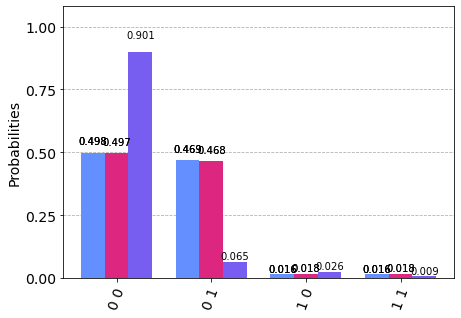

In [16]:
from qiskit.visualization import plot_histogram
counts = job_tomo.result().get_counts()
plot_histogram(counts)


## Tomography

In [17]:
# no correction
state = tomo_state.fit()
# F_state = qi.state_fidelity(state, target_state)
# print("State fidelity (no correction): F = {:.5f}".format(F_state))

In [19]:
state

array([[0.92626953+0.j        , 0.01428223-0.01489258j],
       [0.01428223+0.01489258j, 0.07373047+0.j        ]])

In [18]:
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(result)

QiskitError: "Unexpected state label '0 0', verify the fitter's state labels correspond to the input data"

In [ ]:
# correct data
# correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method="least_squares")
# tomo_state_mit = StateTomographyFitter(correct_tomo_results, qpt_circs)
# rho_fit_bell_mit = tomo_state_mit.fit(method="lstsq")

# F_bell_mit = qi.state_fidelity(rho_fit_bell_mit, target_state_bell)
# print("State fidelity (w/ correction): F = {:.5f}".format(F_bell_mit))

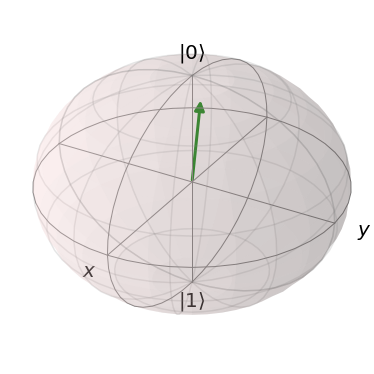

In [ ]:
from qutip import Qobj, Bloch
state = Qobj(state)

b = Bloch()
b.add_states(state)
b.show()

## Plot

(<matplotlib.contour.QuadContourSet at 0x1e4be17ab50>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

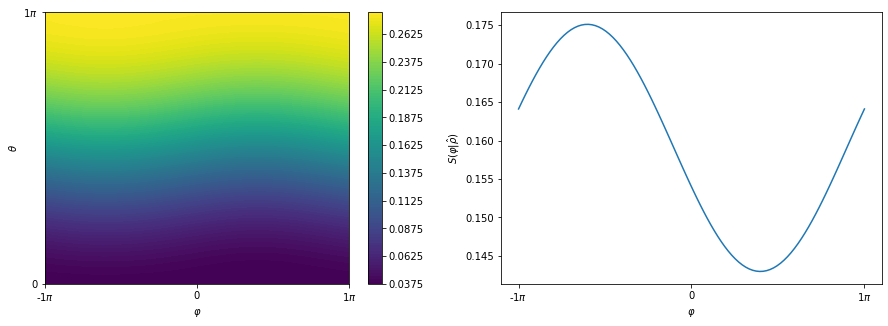

In [ ]:
from sync_calcs import spin_husimi_qfunc, spin_S_measure
from sync_plots import plot_Q_and_S

n = 50

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)

Q = spin_husimi_qfunc(state, theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table